In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

input_data_raw =  pd.read_csv('rnap_scanned_over_ecoli_genome.csv')
sequences = input_data_raw['seq'].tolist()

In [2]:
input_data_raw.head()

,val,seq,left,right,ori,contig
0,23.9083,CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG,3695629,3695669,+,MG1655.fa
1,23.5831,TTTCTGCCCGCGGCCTGGCAATTGATACCGCCTTGCCATCG,1109059,1109099,+,MG1655.fa
2,23.4205,TTTTTACACGCCTTGCGTAAAGCGGCACGGCGCGGGGTGCG,822216,822256,-,MG1655.fa
3,23.4098,TTGCTGCCTGGCCGATGGTCTATGCCGCTGCGTTCTCCGGC,772478,772518,+,MG1655.fa
4,23.3640,CTTTTACACGCAAAATGCCGTCACGTTCACGGGTCTGGGCT,2748531,2748571,+,MG1655.fa


## Make training labels

No handles with labels found to put in legend.


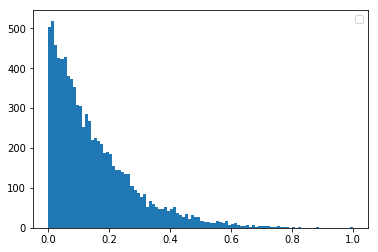

In [3]:
num_sample = 9000   # number of training samples
test_size = 1000    # number of test samples

# positive labels
pos_labels = np.array(input_data_raw['val'][0:num_sample])
# normalize the following between 0 and 1
pos_labels = (pos_labels-min(pos_labels))/(max(pos_labels)-min(pos_labels))

test_pos_labels = np.array(input_data_raw['val'][num_sample:num_sample+test_size])
# normalize the following between 0 and 1
test_pos_labels = (test_pos_labels-min(test_pos_labels))/(max(test_pos_labels)-min(test_pos_labels))

plt.hist(pos_labels,bins=100)
plt.show()


## Collect positive training data

In [4]:
pos = []
test_pos = []

for index in range(len(sequences[0:num_sample])):
    pos.append(list(sequences[index]))
    
for test_index in range(len(sequences[num_sample:num_sample+test_size])):
    test_pos.append(list(sequences[index]))    

pos = np.array(pos)
test_pos = np.array(test_pos)

seq_length = len(pos[0])

## One-hot encoding

In [5]:
pos_tensor = np.zeros(list(pos.shape) + [4])
test_pos_tensor = np.zeros(list(test_pos.shape) + [4])

base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#naive one-hot encoding
for row in range(num_sample):
    for col in range(seq_length):
        pos_tensor[row,col,base_dict[pos[row,col]]] = 1
        if(row<test_size):
            test_pos_tensor[row,col,base_dict[test_pos[row,col]]] = 1

print('Positive sample matrix shape: {}'.format(pos.shape))
# this should be a 3D tensor with shape: (samples, steps, input_dim)
print('Positive sample tensor shape: {}'.format(pos_tensor.shape))

#X = np.vstack((pos_tensor, neg_tensor))
X = pos_tensor
y = pos_labels

X_test = test_pos_tensor
y_test = test_pos_labels

print('Training set shape: {}'.format(X.shape))
print('Training set label shape: {}'.format(y.shape))
print('\nOne-hot encoding looks like:\n {}'.format(X[0,0:10,:]))

Positive sample matrix shape: (9000, 41)
Positive sample tensor shape: (9000, 41, 4)
Training set shape: (9000, 41, 4)
Training set label shape: (9000,)

One-hot encoding looks like:
 [[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


# Define error metrics

In [6]:
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

## Define Models

In [7]:
#here comes the deep learning part
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import SGD, Adam


Using TensorFlow backend.


In [8]:

model = Sequential()
model.add(Conv1D(10, 30, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(5, 20, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.001), metrics=[rmse])
#model.compile(loss='mean_squared_error',optimizer=sgd, metrics=[rmse])

model.summary()

history = model.fit(X, y, validation_split=0.3, epochs=50)  # starts training



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 41, 10)            1210      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 5)             1005      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 5)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
__________

Epoch 48/50
6300/6300 [==============================] - 1s 108us/step - loss: 0.0019 - rmse: 0.0306 - val_loss: 0.0060 - val_rmse: 0.0751
Epoch 49/50
6300/6300 [==============================] - 1s 108us/step - loss: 0.0020 - rmse: 0.0323 - val_loss: 0.0062 - val_rmse: 0.0766
Epoch 50/50
6300/6300 [==============================] - 1s 109us/step - loss: 0.0018 - rmse: 0.0304 - val_loss: 0.0061 - val_rmse: 0.0755


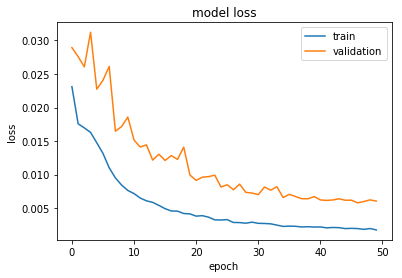

In [9]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [10]:
history.history.keys()

dict_keys(['val_loss', 'val_rmse', 'loss', 'rmse'])

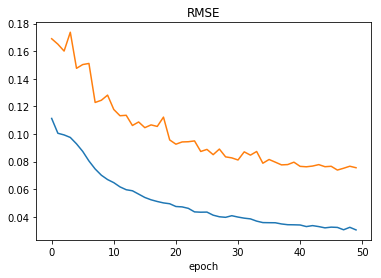

In [11]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('RMSE')
plt.xlabel('epoch')
#plt.legend(['val_r_sq', 'r_sq'], loc='upper left')
plt.show()


In [12]:
#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))

num2seq = ['A','C','G','T']

#''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])
#test_pred = ''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])

Convolution parameter shape: (30, 4, 10)


## Make predictions

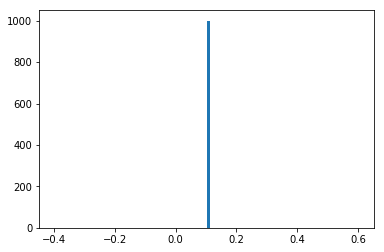

In [13]:
model_prediction = model.predict(X_test)
plt.hist(model_prediction,bins=100)
plt.show()

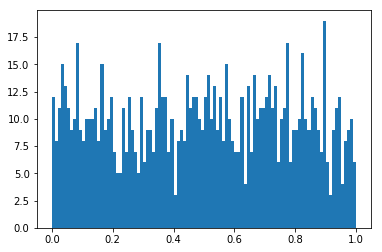

In [14]:
plt.hist(y_test,bins=100)
plt.show()